In [1]:
import pandas as pd
diabetes = pd.read_csv('pima-indians-diabetes.csv')
diabetes.head()

,Number_pregnant,Glucose_concentration,Blood_pressure,Triceps,Insulin,BMI,Pedigree,Age,Class,Group
0,6,0.743719,0.590164,0.353535,0.000000,0.500745,0.234415,50,1,B
1,1,0.427136,0.540984,0.292929,0.000000,0.396423,0.116567,31,0,C
2,8,0.919598,0.524590,0.000000,0.000000,0.347243,0.253629,32,1,B
3,1,0.447236,0.540984,0.232323,0.111111,0.418778,0.038002,21,0,B
4,0,0.688442,0.327869,0.353535,0.198582,0.642325,0.943638,33,1,C


In [2]:
diabetes.columns

Index(['Number_pregnant', 'Glucose_concentration', 'Blood_pressure', 'Triceps',
       'Insulin', 'BMI', 'Pedigree', 'Age', 'Class', 'Group'],
      dtype='object')

### normalize

In [3]:
# we can use sklearn but in this case teacher want to show trick in pandas
cols_to_norm = ['Number_pregnant', 'Glucose_concentration', 'Blood_pressure', 'Triceps',
       'Insulin', 'BMI', 'Pedigree']
diabetes[cols_to_norm] = diabetes[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max()-x.min()))
diabetes[cols_to_norm].head()

,Number_pregnant,Glucose_concentration,Blood_pressure,Triceps,Insulin,BMI,Pedigree
0,0.352941,0.743719,0.590164,0.353535,0.000000,0.500745,0.234415
1,0.058824,0.427136,0.540984,0.292929,0.000000,0.396423,0.116567
2,0.470588,0.919598,0.524590,0.000000,0.000000,0.347243,0.253629
3,0.058824,0.447236,0.540984,0.232323,0.111111,0.418778,0.038002
4,0.000000,0.688442,0.327869,0.353535,0.198582,0.642325,0.943638


### Clean up data

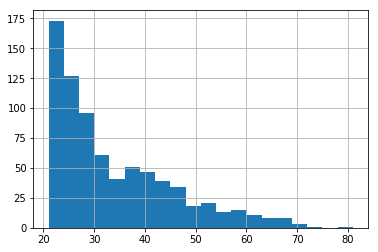

In [30]:
import tensorflow as tf
cols = list(diabetes.drop('Group',axis=1) \
                    .drop('Class',axis=1) \
                    .drop('Age',axis=1)
                    .columns)
feat_cols = []
for c in cols:
    feat_cols.append(tf.feature_column.numeric_column(c))

# Group
group_names = list(diabetes.groupby('Group').groups.keys()) # ['A','B','C','D']
assigned_group = tf.feature_column.categorical_column_with_vocabulary_list('Group',group_names)
feat_cols.append(assigned_group)

# Age [convert to category]
import matplotlib.pyplot as plt
%matplotlib inline
diabetes['Age'].hist(bins=20)

feature_age = tf.feature_column.numeric_column('Age')
age_buckets = tf.feature_column.bucketized_column(feature_age,boundaries=[20,30,40,50,60,70,80])

### Train test split

In [31]:
x_data = diabetes.drop('Class',axis=1)
labels = diabetes['Class']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_data, labels, test_size=0.33, random_state=101)

# Linear Classification
### 1. Train

In [32]:
input_func = tf.estimator.inputs.pandas_input_fn(x=X_train,
                                                y=y_train,
                                                batch_size=10,
                                                num_epochs=1000,
                                                shuffle=True)
model = tf.estimator.LinearClassifier(feature_columns=feat_cols,n_classes=2)
model.train(input_fn=input_func,steps=1000)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/sr/9k0jqkfs33q22ppyt_t7yjt9716826/T/tmp7ng7myh3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1a28f83080>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/sr/9k0jqkfs33q22ppyt_t7yjt9716826/T/tmp7ng7myh3/model.ckpt.
INFO:tensorflow:loss = 6.93147, step = 1
INFO:tensorflow:global_step/sec: 452.663
INFO:tensorflow:loss = 6.4058, step = 101 (0.222 sec)
INFO:tensorflow:global_step/sec: 631.623
INFO:tensorflow:loss = 6.9383, step = 2

### 2. Evaluate [Test]

In [33]:
eval_input_func = tf.estimator.inputs.pandas_input_fn(
      x=X_test,
      y=y_test,
      batch_size=10,
      num_epochs=1,
      shuffle=False)
result = model.evaluate(eval_input_func)
result

INFO:tensorflow:Starting evaluation at 2018-02-27-03:27:22
INFO:tensorflow:Restoring parameters from /var/folders/sr/9k0jqkfs33q22ppyt_t7yjt9716826/T/tmp7ng7myh3/model.ckpt-1000
INFO:tensorflow:Finished evaluation at 2018-02-27-03:27:23
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.724409, accuracy_baseline = 0.65748, auc = 0.791727, auc_precision_recall = 0.644338, average_loss = 0.552108, global_step = 1000, label/mean = 0.34252, loss = 5.39367, prediction/mean = 0.334692


{'accuracy': 0.72440946,
 'accuracy_baseline': 0.65748036,
 'auc': 0.79172695,
 'auc_precision_recall': 0.64433807,
 'average_loss': 0.55210769,
 'global_step': 1000,
 'label/mean': 0.34251967,
 'loss': 5.3936672,
 'prediction/mean': 0.33469164}

### 3. Prediction

In [34]:
pred_input_func = tf.estimator.inputs.pandas_input_fn(
    x=X_test,
    batch_size=10,
    num_epochs=1,
    shuffle=False
)
predictions = model.predict(pred_input_func)
list(predictions)

INFO:tensorflow:Restoring parameters from /var/folders/sr/9k0jqkfs33q22ppyt_t7yjt9716826/T/tmp7ng7myh3/model.ckpt-1000


[{'class_ids': array([0]),
  'classes': array([b'0'], dtype=object),
  'logistic': array([ 0.26170728], dtype=float32),
  'logits': array([-1.03711379], dtype=float32),
  'probabilities': array([ 0.73829269,  0.26170728], dtype=float32)},
 {'class_ids': array([0]),
  'classes': array([b'0'], dtype=object),
  'logistic': array([ 0.4577193], dtype=float32),
  'logits': array([-0.16952765], dtype=float32),
  'probabilities': array([ 0.54228073,  0.45771933], dtype=float32)},
 {'class_ids': array([0]),
  'classes': array([b'0'], dtype=object),
  'logistic': array([ 0.26692337], dtype=float32),
  'logits': array([-1.01028872], dtype=float32),
  'probabilities': array([ 0.73307669,  0.26692337], dtype=float32)},
 {'class_ids': array([0]),
  'classes': array([b'0'], dtype=object),
  'logistic': array([ 0.30745247], dtype=float32),
  'logits': array([-0.81205636], dtype=float32),
  'probabilities': array([ 0.69254756,  0.30745247], dtype=float32)},
 {'class_ids': array([0]),
  'classes': array

# DNN Classifier

### group for DNN need to use embedded group column

In [54]:
embedded_group_column = tf.feature_column.embedding_column(assigned_group, dimension=len(group_names))
feat_cols[7] = embedded_group_column

### 1. Train

In [50]:
input_func = tf.estimator.inputs.pandas_input_fn(x=X_train,y=y_train,batch_size=10,num_epochs=1000,shuffle=True)
dnn_model = tf.estimator.DNNClassifier(hidden_units=[10,10,10],feature_columns=feat_cols,n_classes=2)
dnn_model.train(input_fn=input_func,steps=1000)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/sr/9k0jqkfs33q22ppyt_t7yjt9716826/T/tmp8ne06nkg', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1a2977ac88>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/sr/9k0jqkfs33q22ppyt_t7yjt9716826/T/tmp8ne06nkg/model.ckpt.
INFO:tensorflow:loss = 7.17077, step = 1
INFO:tensorflow:global_step/sec: 428.167
INFO:tensorflow:loss = 6.28819, step = 101 (0.235 sec)
INFO:tensorflow:global_step/sec: 581.635
INFO:tensorflow:loss = 6.85699, step =

### 2. Evaluate [Test]

In [52]:
eval_input_func = tf.estimator.inputs.pandas_input_fn(x=X_test,y=y_test,batch_size=10,num_epochs=1,shuffle=False)
dnn_model.evaluate(eval_input_func)

INFO:tensorflow:Starting evaluation at 2018-02-27-03:43:55
INFO:tensorflow:Restoring parameters from /var/folders/sr/9k0jqkfs33q22ppyt_t7yjt9716826/T/tmp8ne06nkg/model.ckpt-1026
INFO:tensorflow:Finished evaluation at 2018-02-27-03:43:56
INFO:tensorflow:Saving dict for global step 1026: accuracy = 0.767717, accuracy_baseline = 0.65748, auc = 0.841042, auc_precision_recall = 0.722472, average_loss = 0.46549, global_step = 1026, label/mean = 0.34252, loss = 4.54748, prediction/mean = 0.340803


{'accuracy': 0.76771653,
 'accuracy_baseline': 0.65748036,
 'auc': 0.84104204,
 'auc_precision_recall': 0.72247231,
 'average_loss': 0.46548995,
 'global_step': 1026,
 'label/mean': 0.34251967,
 'loss': 4.5474792,
 'prediction/mean': 0.34080309}